# House Prices - Regression Predictions YData 2024
Team: AcadEMY

Team mates: Eran T, Maya L, Yair BH, Adir Golan.

In [25]:
from sklearn.model_selection import StratifiedKFold

# Imports
from utils import load_house_prices_data
from utils import calc_num_missing_vals_per_col, np
from plot_utils import plot_num_missing_values
from plot_utils import plot_price_dist_per_year
from plot_utils import plot_column_histograms
from plot_utils import plot_numeric_features_correlation_to_target
from plot_utils import plot_head_and_tail_categorical_corr_to_target
from utils import calc_categorical_feature_correlation_to_target
from utils import calc_numeric_feature_correlation
from plot_utils import plot_mean_price_and_stddev_per_category
from preprocessing import preprocess
from plot_utils import plot_number_of_sales_and_prices_across_time

## Part 1 - EDA

In [26]:
train_origin_df = load_house_prices_data('train')
train_features = train_origin_df.drop('SalePrice', axis='columns')

### 1.1 Which 3 features have the highest number of missing values?

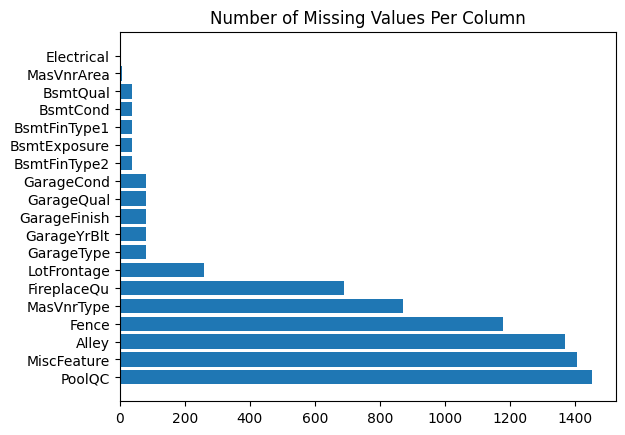

Top 3 features with the most missing values: ['PoolQC' 'MiscFeature' 'Alley']


In [27]:
num_of_nans = calc_num_missing_vals_per_col(train_features)

plot_num_missing_values(num_of_nans)

max_nans = num_of_nans.nlargest(3).index
print(f"Top 3 features with the most missing values: {max_nans.values}")

### 1.2 How does the price behave over the years?

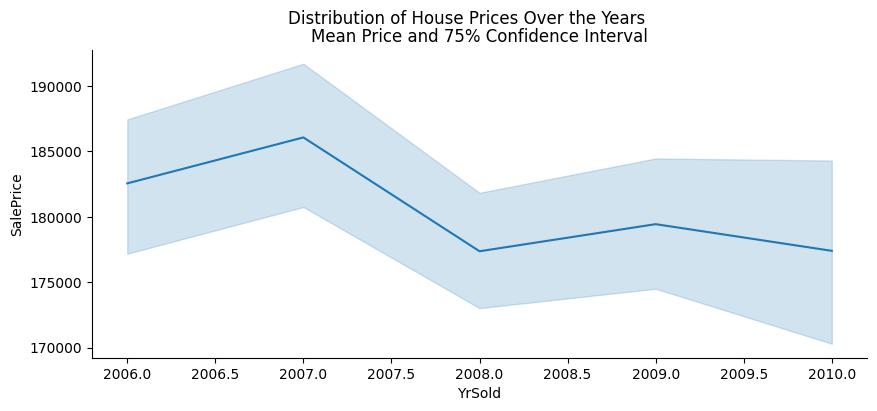

In [28]:
plot_price_dist_per_year(train_origin_df)

Graph Insight:
Over the 4 years shown, the mean price have fluctuated; increasing until 2007, with a down movement overall.

### 1.3 Plotting feature distribution using histograms

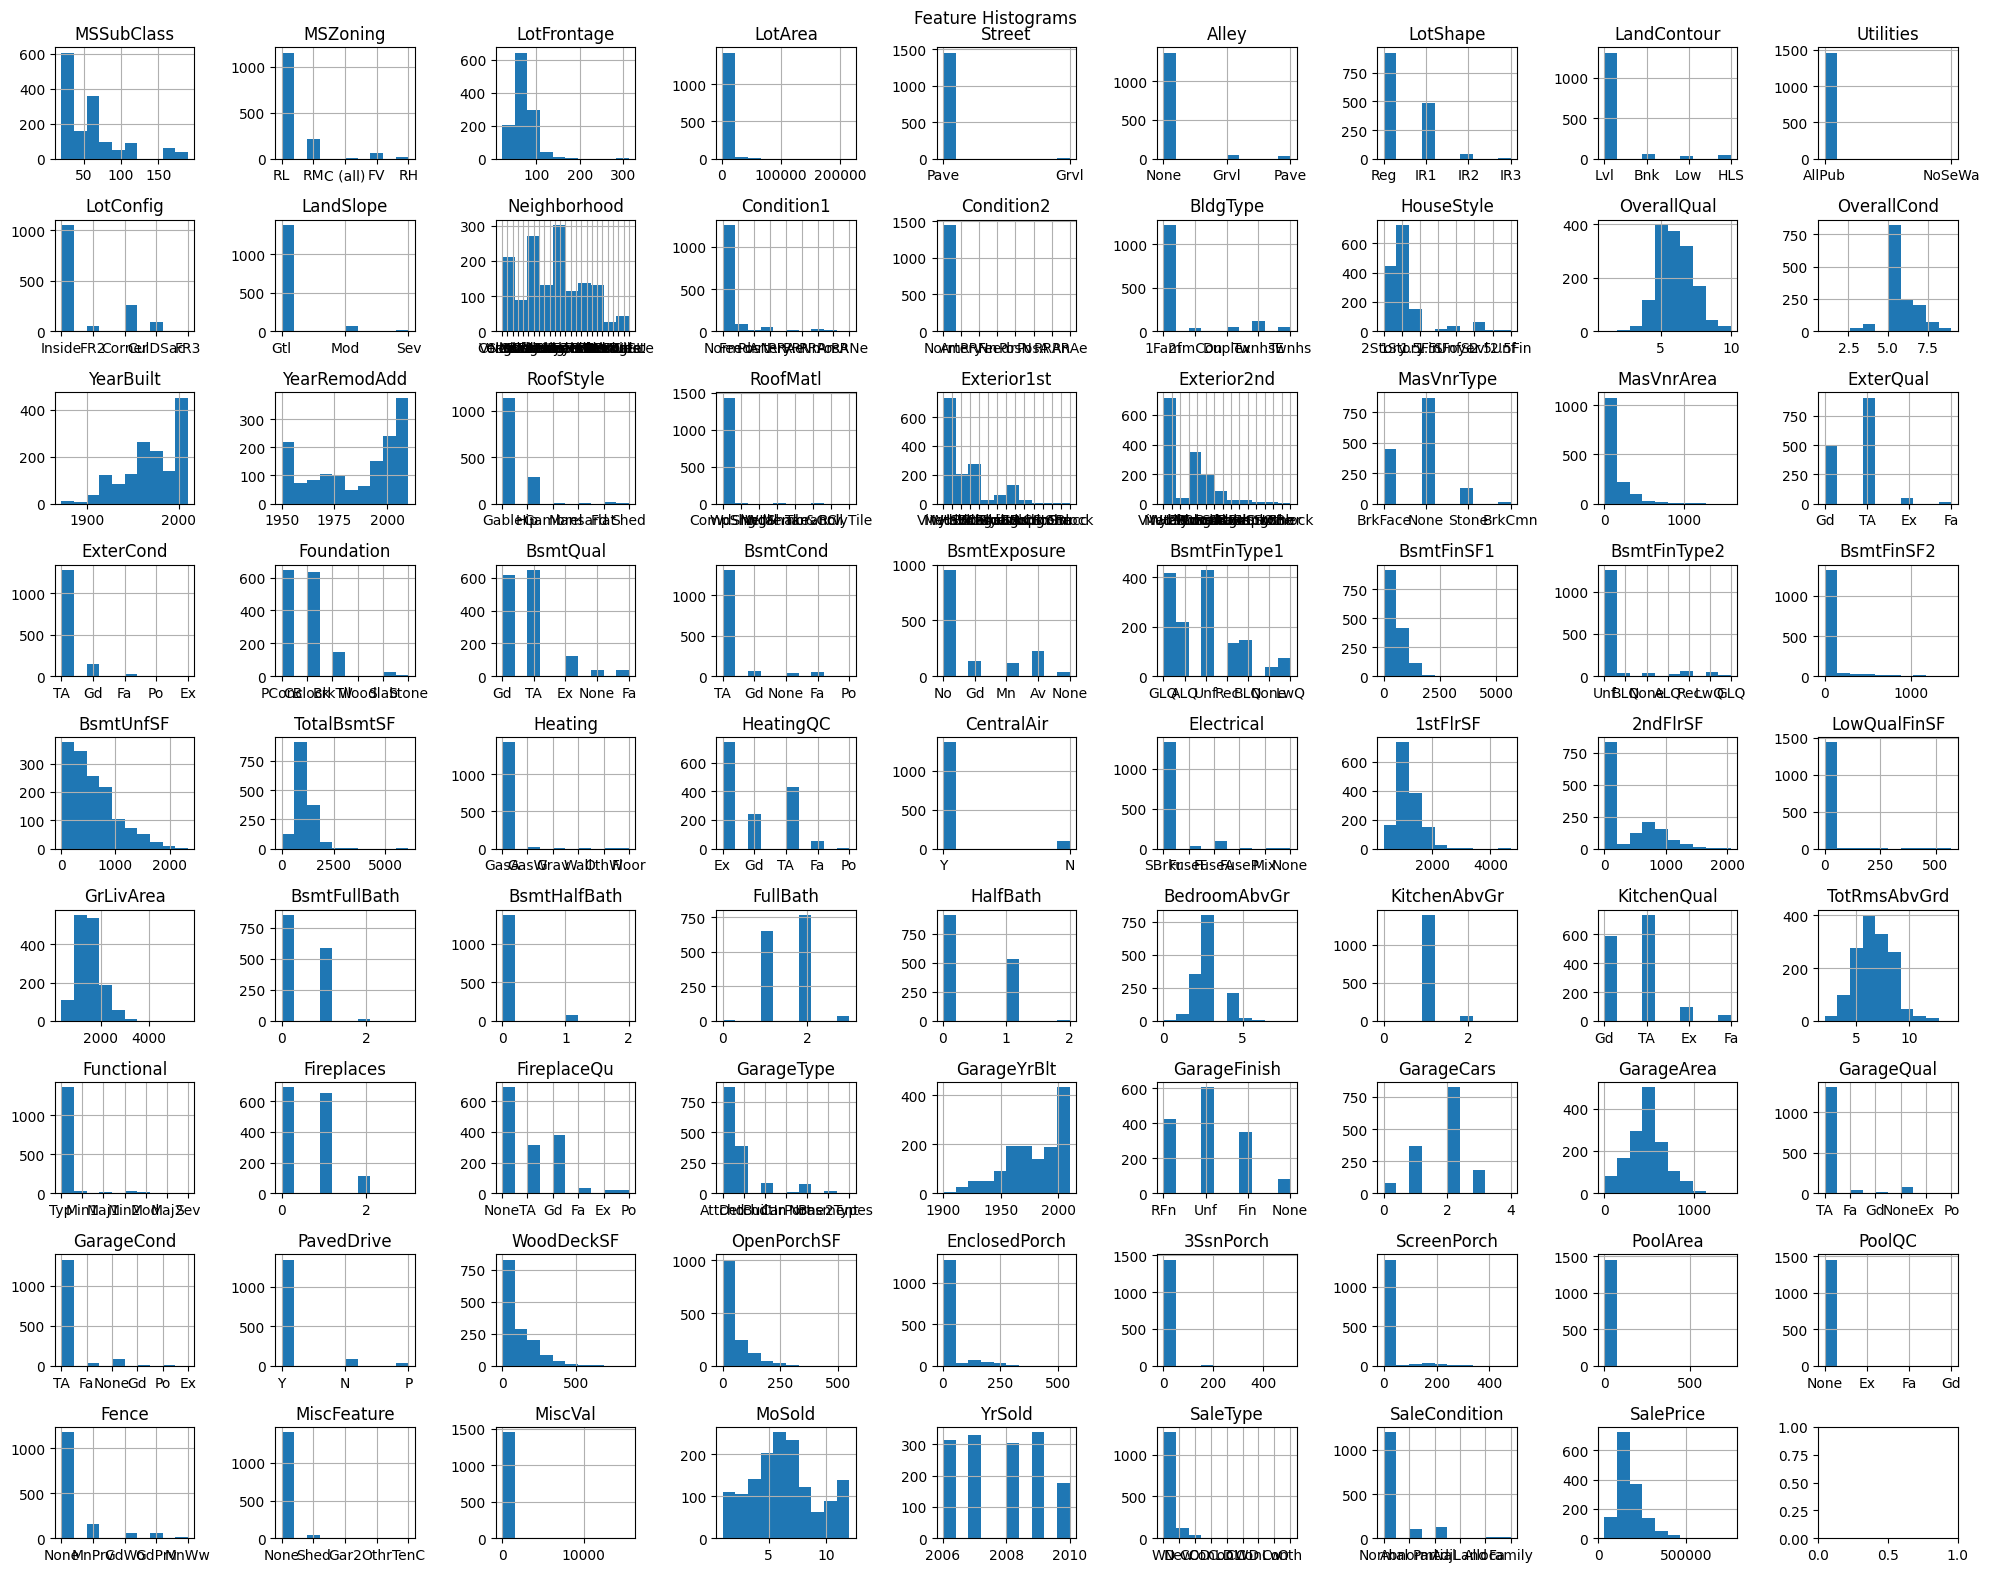

In [29]:
plot_column_histograms(train_origin_df)

Graph insights:
- Many unbalanced categorical features, including "SaleType","GarageCond","PavedDrive","Street".
- Some numerical feature resemble a normal distribution: "OverallQual","TotRmsAbvGrd", "GarageArea".
- There is a consistent increase in the number of houses built per year.
- There is seasonality in the month sold - most sales happen in summer (June, July) and least happen in winter (September, October).

### 1.4 Computing Feature Correlation to Label

#### Numeric Features

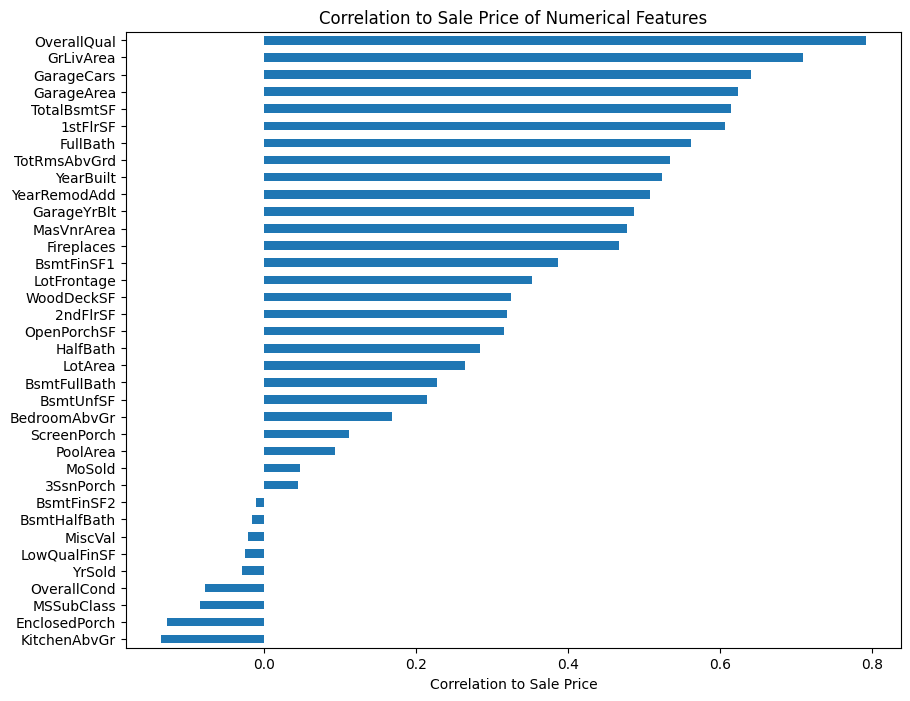

In [30]:
corr_vector = train_origin_df.select_dtypes(include='number').corr()['SalePrice'].sort_values().drop('SalePrice', axis=0)

plot_numeric_features_correlation_to_target(corr_vector)

Graph insights:
- The number of kitchens above ground has the most negative correlation to the house price.
- "BsmtFinSF2" has little to no correlation to the price.
- "OverallQual" has the highest positive correlation, while "OverallCond" has somewhat negative correlation, meaning physical condition matters less than subjective measures.
- The top 5 features correlated to price mean that people value quality, area of living and garage space. 

#### Categorical Features

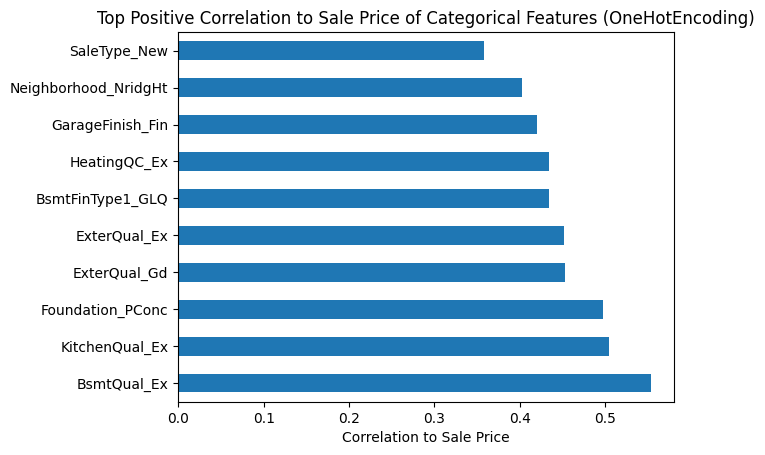

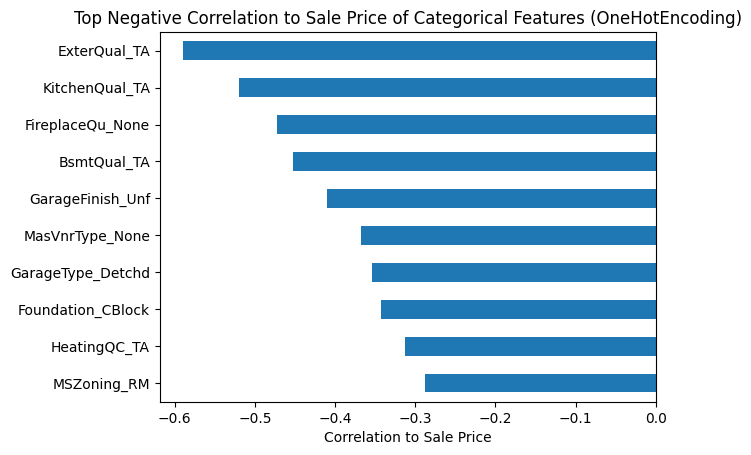

In [31]:
from plot_utils import plot_head_and_tail_categorical_corr_to_target
from utils import calc_categorical_feature_correlation_to_target

sorted_correlation = calc_categorical_feature_correlation_to_target(train_origin_df)

plot_head_and_tail_categorical_corr_to_target(sorted_correlation)

### 1.5 More EDA that will help us understand the data and support our modelling decisions

#### Feature selection (searching features that can be dropped)
The idea is that due to the large number of features in the original dataset (80, not including the target), it might be beneficial to reduce the number of features. We do this in different ways:

##### Highly correlated numerical features
We looked for highly correlated features and decided to drop one of each pair:

In [32]:
numeric_correlations = calc_numeric_feature_correlation(train_features)
threshold = 0.7
highly_correlated_numeric_features = [t for t in numeric_correlations if t[2] >= threshold]

print(highly_correlated_numeric_features)

[('YearBuilt', 'GarageYrBlt', 0.826), ('TotalBsmtSF', '1stFlrSF', 0.82), ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('GarageCars', 'GarageArea', 0.882)]


In [33]:
#features to drop due to high correlation with another feature (one from each pair):
# we drop features that are not common to all samples (e.g., all buildings must have YearBuilt but not necessarily GarageYrBlt)
high_correlated_features_to_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']

##### Correlation of categorical object type features with the target
By plotting the categorical distributions of each (categorical) feature with respect to the target, we can choose specific features that seem to hold few meaningful information (mostly features with approximately uniform distribution or highly imbalanced distribtion).

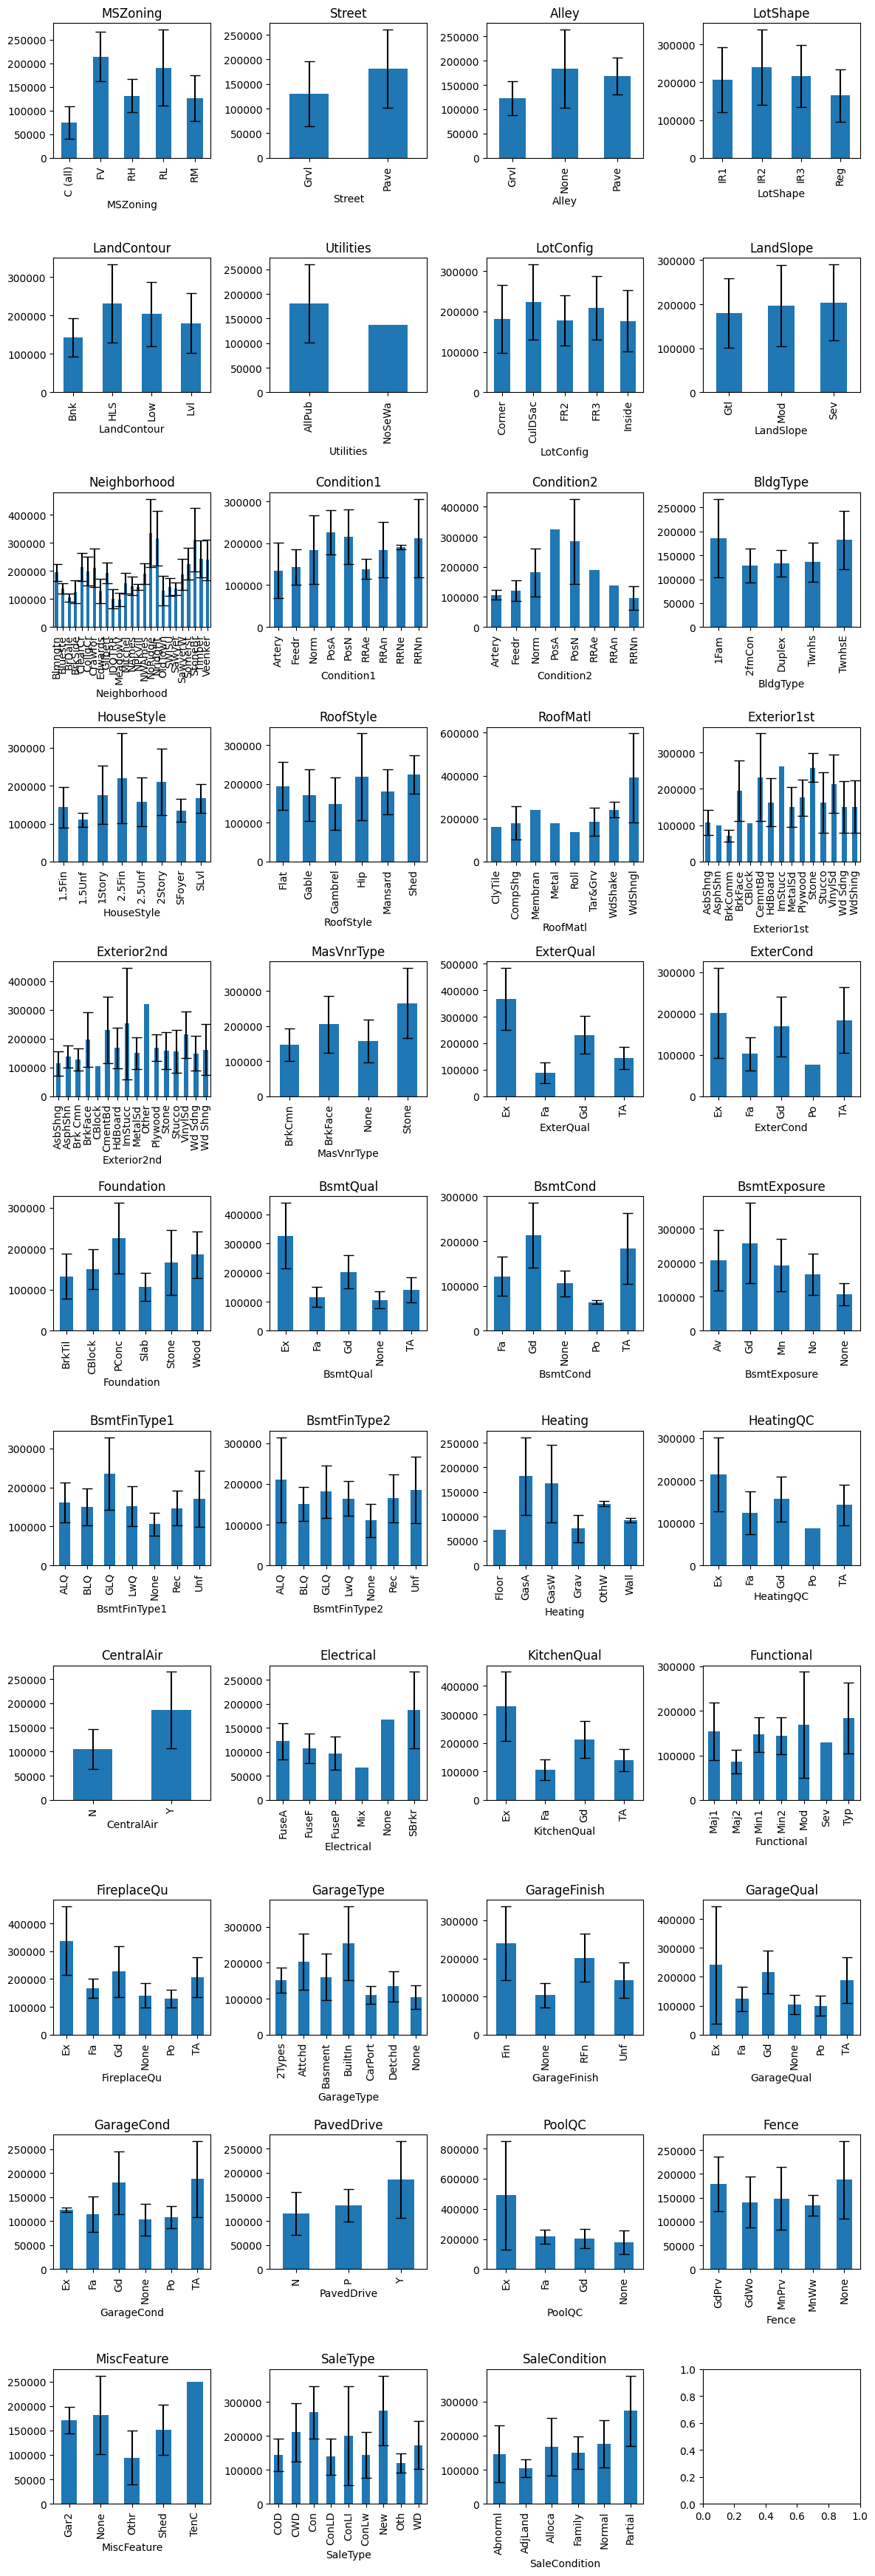

In [34]:
# Finding correlation (indirectly) between 'object' features and target:
plot_mean_price_and_stddev_per_category(train_origin_df)

In [35]:
# Object features that show low correlation to target (by indirect impression):
cat_cols_uncor_w_target = ['LotShape', 'LandContour', 'LotConfig',
                           'LandSlope', 'Condition2', 'RoofMatl', 'BsmtExposure',
                           'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                           'Functional', 'Fence', 'MiscFeature'
                           ]

##### Numerical features with imbalanced data

In [36]:
#numerical features to drop due to high imbalance of the data:
drop_imbalanced = ['Heating', 'Alley', 'Street', 'Utilities']


##### Feature engineering on pool information + Filling na in LotFrontage

In [37]:
# only 7 samples with pool, but might be important, so:
# we create new *binary* feature 'HavePool' and drop 'PoolQC' 'PoolArea'

# And replacing missing values in 'LotFrontage' with mean values:

filtered_preprocessed_df = preprocess(train_origin_df)

#### Understanding The Data

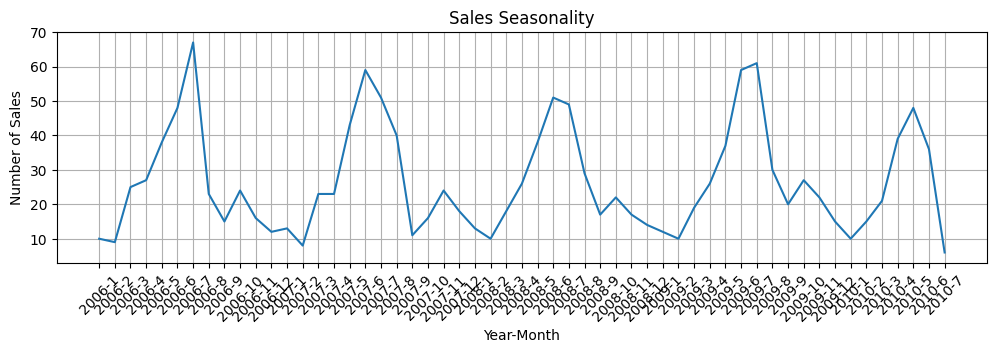

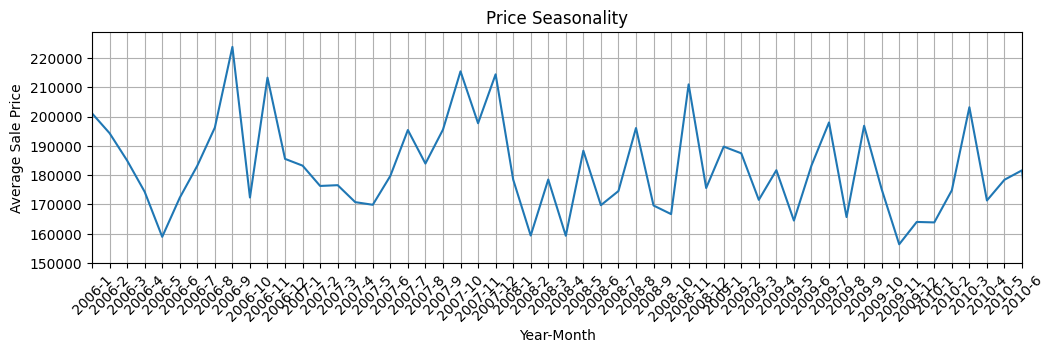

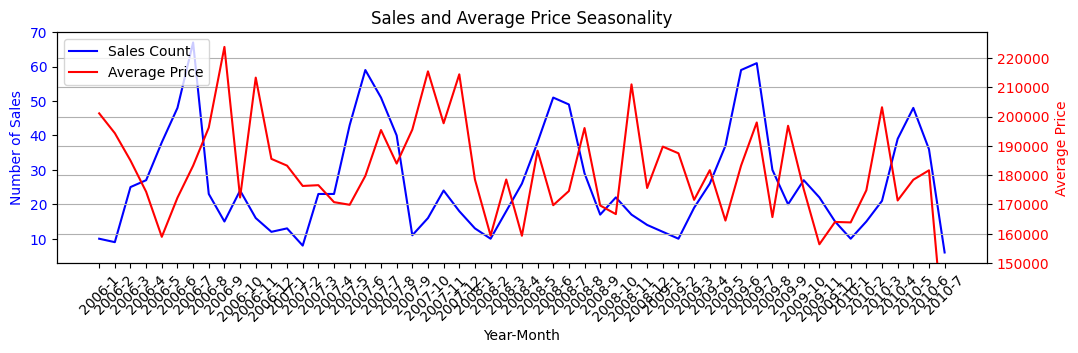

In [38]:
from plot_utils import plot_number_of_sales_and_prices_across_time

plot_number_of_sales_and_prices_across_time(train_origin_df)

The plots above demonstrate pretty clear seasonality in two features: 
* Sales seasonality: we can see a peak in the number of sales on a yearly basis around May-June, followed by a decrease in sales from June to January, with mainly January as the weakest month. 
* Price seasonality: We can see some seasonality in sales prices, albeit less consistent than in the number of sales case. 

Instrestingly, by looking at the combined plot we can see some periods where the number of sales drops down drastically while average price hits a peak. 

## Part 2 - Baseline Model

Our baseline model is a linear regression with default params, trained on the entire training set, on which we applied some NA filling on 'GarageYrBuilt', imputed all other NANs with zeros, and then we worked only on the numeric features, scaled using RobustScaler.
See the flow_config.py for more information.

In [39]:
# This is the configuration used in the baseline:
from flow_config import (get_raw_data_packs,
                         feature_target_separation_packs,
                         preprocessing_packs,
                         labeling_packs,
                         model_grid_search_params)
from sklearn.pipeline import make_pipeline
from model_flow import prepare_submission_csv

get_raw_data_func = get_raw_data_packs['V0']['function']  # just loads the dataframes
feature_target_separation_func = feature_target_separation_packs['V0']['function']  # separates the sale price
baseline_preprocessing_config = preprocessing_packs['V0']  # see config
labeling_func = labeling_packs['V0']['function']  # does nothing to the sale price
baseline_model = model_grid_search_params['LinearRegression']['class']()


# executing baseline
train_raw_data, test_raw_data = get_raw_data_func()

train_X, train_y = feature_target_separation_func(train_raw_data)
test_X, test_y = feature_target_separation_func(test_raw_data)

preprocess_pipe = make_pipeline(*baseline_preprocessing_config['steps'])
preprocess_pipe.fit(train_X)

train_preprocessed_X = preprocess_pipe.transform(train_X)
test_preprocessed_X = preprocess_pipe.transform(test_X)

baseline_model.fit(train_preprocessed_X, train_y)

test_y_pred = baseline_model.predict(test_preprocessed_X)

# if you want to save the file, uncomment this line:
# prepare_submission_csv(test_X.index.values, test_y_pred.flatten())

## Part 3 - More Advanced Manipulations and Modeling

We'll go over our best configuration with which we got the leaderboard score of 0.1488. 

### Sample Filtering
Instead of training on all the train set, we filtered out some samples based on the GrLivArea column:

In [40]:
best_get_raw_data_pack = "V1"  # train_raw_data = train_raw_data[train_raw_data[GrLivArea] <= 4000]

### Cross Validation Method
After looking at top solutions for this dataset, we saw all users used basic KFold, instead of a time-based splitter, and in the end it did output better result.

In [41]:
best_cross_validation_pack = "KFold"  # "args": {"n_splits": 10, "shuffle": True, "random_state": 42}

### Feature Extraction
Most features we extracted were binarization, where we add a binary indicator for the existence of the feature,
for example 'HasPool' instead of the pool's area.

We also grouped some categories together.

The feature extraction was done by applying many functions in a sequential order.
Each function pretty much explains what it does (you can go to each function to see the exact implementation).

The RelativeFeatureExtractor is the most complex one, and it extracts some features that are based on a sample's relative position in the training set. The new features:
    - SizeRelativeToMedian - TotalArea divided by the median TotalArea of the neighborhood
    - IsInTopQuartile - 1 if TotalArea is in the top 15% of the neighborhood
    - NeibLevel - Neighborhood pricing level

In [42]:
best_feature_extraction_pack = "V1"

"""
"V1": {"steps": [NoFitPreProcessor([join_porch_areas,
                                        join_liv_bsmt_areas,
                                        group_exterior_covering,
                                        group_roofstyle_roofmatl,
                                        binarize_year_remodeled,
                                        extract_asset_age,
                                        join_bathrooms,
                                        binarize_pool,
                                        binarize_second_floor,
                                        binarize_garage,
                                        binarize_basement,
                                        binarize_fireplace,
                                        extract_garage_age]),
                     RelativeFeatureExtractor()]}
                     """


'\n"V1": {"steps": [NoFitPreProcessor([join_porch_areas,\n                                        join_liv_bsmt_areas,\n                                        group_exterior_covering,\n                                        group_roofstyle_roofmatl,\n                                        binarize_year_remodeled,\n                                        extract_asset_age,\n                                        join_bathrooms,\n                                        binarize_pool,\n                                        binarize_second_floor,\n                                        binarize_garage,\n                                        binarize_basement,\n                                        binarize_fireplace,\n                                        extract_garage_age]),\n                     RelativeFeatureExtractor()]}\n                     '

### Preprocessing
After many iterations, we found that these pipeline steps are the best:

In [43]:
best_preprocessing_pack = "V7"

"""
"V7": {"steps": [NoFitPreProcessor([preprocess]),
                 ColumnTransformer(transformers=[
                     ('common_cat', COMMON_CATEGORICAL_ORDINAL_ENCODER1, COMMON_CATEGORICAL_FEATURES1),
                     ('common_cat2', COMMON_CATEGORICAL_ORDINAL_ENCODER2, COMMON_CATEGORICAL_FEATURES2),
                     ('uncommon_cat', UNCOMMON_CATEGORICAL_ORDINAL_ENCODER, UNCOMMON_CATEGORICAL_FEATURES),
                     ('one_hot1',
                      OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                      [Neighborhood, SaleType, MoSold, YrSold, MSSubClass, MSZoning])
                 ],
                     remainder='passthrough',
                     verbose_feature_names_out=False,
                 ),
                 NoFitPreProcessor([drop_known_columns,
                                    drop_globally_gathered_columns,
                                    lambda d: d.select_dtypes(include='number')]),
                 SimpleImputer(missing_values=pd.NA, strategy="constant", fill_value=0).set_output(
                     transform='pandas'),
                 RobustScaler()
                 ]
"""

'\n"V7": {"steps": [NoFitPreProcessor([preprocess]),\n                 ColumnTransformer(transformers=[\n                     (\'common_cat\', COMMON_CATEGORICAL_ORDINAL_ENCODER1, COMMON_CATEGORICAL_FEATURES1),\n                     (\'common_cat2\', COMMON_CATEGORICAL_ORDINAL_ENCODER2, COMMON_CATEGORICAL_FEATURES2),\n                     (\'uncommon_cat\', UNCOMMON_CATEGORICAL_ORDINAL_ENCODER, UNCOMMON_CATEGORICAL_FEATURES),\n                     (\'one_hot1\',\n                      OneHotEncoder(drop=\'first\', handle_unknown=\'ignore\', sparse_output=False),\n                      [Neighborhood, SaleType, MoSold, YrSold, MSSubClass, MSZoning])\n                 ],\n                     remainder=\'passthrough\',\n                     verbose_feature_names_out=False,\n                 ),\n                 NoFitPreProcessor([drop_known_columns,\n                                    drop_globally_gathered_columns,\n                                    lambda d: d.select_dtypes(include=\

* 'preprocess' - _fill_na_GarageYrBlt_w_YearBuilt, _convert_nan_to_str in categorical columns, _fill_na_LotFrontage_w_neib_median, _convert_month_year_to_cat
* 'drop_known_columns' - drops columns with low correlation to target, some imbalanced features, and features that are correlated to one another.
* 'drop_globally_gathered_columns' - All columns that are dropped, are dropped in this function.
* 'RobustScaler', as its name suggests, is less sensitive to outliers.

### Manipulation of the target values
When the target values are normally distributed, the model's job is easier (most of the time).
By converting the sale price to log of the sale price, we achieved this:

In [44]:
best_labeling_pack = "V1"

"""
"V1": {"function": produce_log_target,
       "scorer": rmse_scorer,  # because the target is now log, we need to adjust the scoring accordingly
       "inverse": lambda predictions: np.expm1(predictions)}
"""

'\n"V1": {"function": produce_log_target,\n       "scorer": rmse_scorer,  # because the target is now log, we need to adjust the scoring accordingly\n       "inverse": lambda predictions: np.expm1(predictions)}\n'

### Modeling
The model which performed best for us was RandomForestRegressor.
All other models over fit on the validation set.

In [45]:
best_model_pack = "RandomForestRegressor"

"""
"RandomForestRegressor": {"class": RandomForestRegressor,
                              "args": {'n_jobs': [-1],
                                       'n_estimators': [100, 3000],
                                       'max_depth': [4, 80, None],
                                       'random_state': [42]
                                       }
                              }
"""

'\n"RandomForestRegressor": {"class": RandomForestRegressor,\n                              "args": {\'n_jobs\': [-1],\n                                       \'n_estimators\': [100, 3000],\n                                       \'max_depth\': [4, 80, None],\n                                       \'random_state\': [42]\n                                       }\n                              }\n'

### Putting it all together

In [50]:
import pandas as pd
from model_flow import tune_hyper_params
from flow_config import feature_extraction_packs, cross_validation_packs

get_raw_data_func = get_raw_data_packs[best_get_raw_data_pack]['function']  # just loads the dataframes
feature_target_separation_func = feature_target_separation_packs['V0']['function']  # separates the sale price
best_feature_extraction_config = feature_extraction_packs[best_feature_extraction_pack]
best_preprocessing_config = preprocessing_packs[best_preprocessing_pack] 
best_labeling_config = labeling_packs[best_labeling_pack]
best_cv_config = cross_validation_packs[best_cross_validation_pack]
best_model_config = model_grid_search_params[best_model_pack]

# data loading
train_raw_data, test_raw_data = get_raw_data_func()

# Feature Extraction
best_feature_extraction_pipeline = make_pipeline(*best_feature_extraction_config['steps']).set_output(transform='pandas')

train_extracted_data = best_feature_extraction_pipeline.fit_transform(train_raw_data)
test_extracted_data = best_feature_extraction_pipeline.transform(test_raw_data)

# Feature-Target Separation
train_X, train_y = feature_target_separation_func(train_extracted_data)
test_X, _ = feature_target_separation_func(test_extracted_data)

# Preprocessing
preprocess_pipe = make_pipeline(*best_preprocessing_config['steps']).set_output(transform='pandas')
preprocess_pipe.fit(train_X)

train_preprocessed_X = preprocess_pipe.transform(train_X)
test_preprocessed_X = preprocess_pipe.transform(test_X)

# Target Manipulation
train_y = best_labeling_config['function'](train_y)

# Cross Validation and GridSearch
cv_splitter = best_cv_config['class'](**best_cv_config['args'])
clf = tune_hyper_params(train_preprocessed_X,
                        train_y,
                        cv_splitter,
                        best_model_config, scorer=best_labeling_config['scorer'])

print(f"Found best estimator. Best cv score: {clf.best_score_}, Best params: {clf.best_params_}")

# Predicting on the entire test set with the best estimator
test_y_pred_ = clf.best_estimator_.predict(test_preprocessed_X)

# Converting back from log scale to regular scale
test_predictions = best_labeling_config['inverse'](test_y_pred_)

test_predictions_series = pd.Series(test_predictions, index=test_preprocessed_X.index)

C:\ProgramData\miniconda3\envs\py4dp\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Found best estimator. Best cv score: -0.13513915456573453, Best params: {'max_depth': 80, 'n_estimators': 3000, 'n_jobs': -1, 'random_state': 42}


In [ ]:
# if you want to save the file, uncomment this line:
# test_predictions_series.to_csv("predictions.csv", index=True)